**Autheur : `SERGE DOUDOU`**

Objectif : Modèle de classification des URL

# I- Etude et création de modèles 

# Importations

In [81]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.parse import urlparse

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE


import time


df = pd.read_csv('data/dataset(1).csv')

## Visualisation des données

In [82]:
df.head()

,domain,label
0,http://sprint.com/business/solutions/mobility_...,0.0
1,hesperia.gsfc.nasa.gov/~schmahl/nnls/,0.0
2,http://web.de/magazine/digital/sicher-im-netz/...,0.0
3,www.wired.com/science/discoveries/news/1999/08...,0.0
4,thomas.arnatt.com/wp-includes/pono/AOL_Logio.htm,1.0


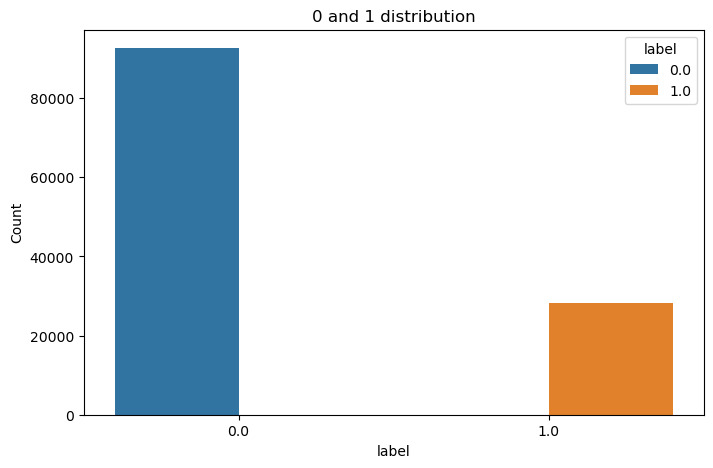

In [4]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='label', hue='label')

plt.xlabel('label')
plt.ylabel('Count')
plt.title('0 and 1 distribution')

plt.show()

In [83]:
df.label.value_counts(normalize = True)*100

0.0    76.601372
1.0    23.398628
Name: label, dtype: float64

On remarque qu'il y a **77%** des url qui ne sont pas de phishing et **23%** qui sont des urls de phisihing.
Il y a donc un déséquilibre dans le dataset. Pour resoudre le déséquilibre on peut faire une augmentation de données.

Dans un 1er temps créons un modèle simple de classification avec la regression logistique sans augmentation de données et voir comment le modèle se comporte.
Dans un seconde temps, nous envisageons de tester plusieurs modèles.

La métrique que nous allons le plus regarder est le **recall**

## Fonctions

In [5]:
def extract_features(data):
    ''' 
       Retourne url une url sans les slash (/)


    '''
    data['url_segments'] = data['domain'].apply(lambda x: x.split('/'))
    data['url_segments_str'] = data['url_segments'].apply(lambda x: ' '.join(x))
    return data['url_segments_str']


def split_1(df):
    ''' 
        Retourne un dataset divise a 80% pour train et 20% pour le test qui sont vectoriser par tfidf.
       
    
    '''
    X = extract_features(df)
    y = df['label']
    X_train_str, X_test_str, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    vectorizer = TfidfVectorizer(ngram_range=(1, 3))
    X_train = vectorizer.fit_transform(X_train_str)
    X_test = vectorizer.transform(X_test_str)
    return X_train, X_test, y_train, y_test

def apply_model(X_train, y_train, X_test, y_test, model):

    ''' 
        Effectue l'entrainement d'un modèle et faire l'évaluation.
    '''

    start_time = time.time()  
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    end_time = time.time() 
    execution_time = end_time - start_time 
    
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")
    print(f"Classification Report:\n {classification_report(y_test, y_pred)}")
    print(f"Execution Time: {execution_time:.4f} seconds")
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



## Création d'un modéle simple : Regression logistique

In [87]:
X_train, X_test, y_train, y_test = split_1(df)

Accuracy: 0.9594594594594594
Confusion Matrix:
 [[18467   144]
 [  837  4750]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     18611
         1.0       0.97      0.85      0.91      5587

    accuracy                           0.96     24198
   macro avg       0.96      0.92      0.94     24198
weighted avg       0.96      0.96      0.96     24198

Execution Time: 18.4896 seconds


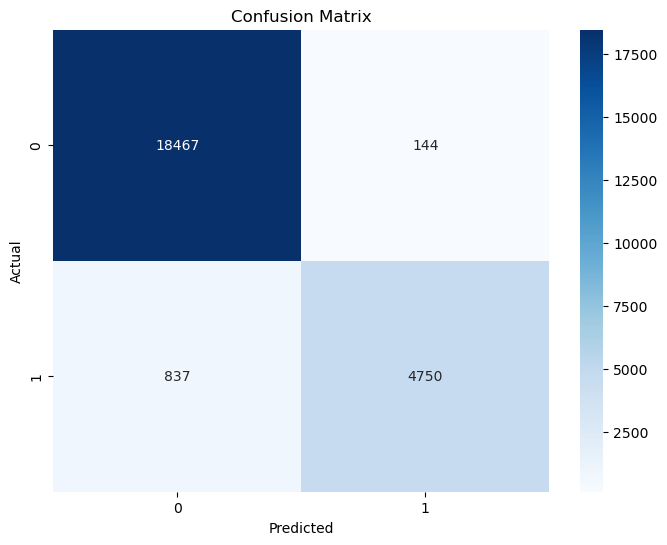

In [36]:

logistic_model = LogisticRegression(random_state=42, max_iter=5000)
apply_model(X_train, y_train, X_test, y_test, logistic_model)

On obeserve que 837 url de phishing on été prédit comme des bons légitimes et 144 url légitimes ont été prédits comme phisihing. De plus, le recall est de **99%** pour les url 
légitimes et de 85% pour les url de phishing.
Ce resultat se justifie au fait qu'il y a beaucoup d'url légitimes et peu d'url de phsishings. 

Pour améliorer les resultats, nous envisageons une augmentation des données, plus précisement des urls de phishing (la classe minoritaire)

## Regression logistique et **Augmentation de données** -- SMOTE


SMOTE (Synthetic Minority Oversampling Technique) est une technique statistique permettant d’augmenter le nombre de cas d’un jeu de données de façon équilibrée. Le composant fonctionne par génération de nouvelles instances à partir de cas minoritaires fournis en entrée. Cette implémentation de SMOTE ne modifie pas le nombre de cas majoritaires

[**plus d'infos ?**](https://learn.microsoft.com/fr-fr/azure/machine-learning/component-reference/smote?view=azureml-api-2)

In [88]:
def split_2(X_train, y_train):

    
    ''' 
        Retourne une augmentation de données sur les jeu d'entrainement (equilibre entre les deux classes minoritaire et majoritaire)
    
    '''
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    return X_train_smote, y_train_smote

X_train_smote, y_train_smote= split_2(X_train, y_train)

### Distribution avant augmentation du train de 0 et 1

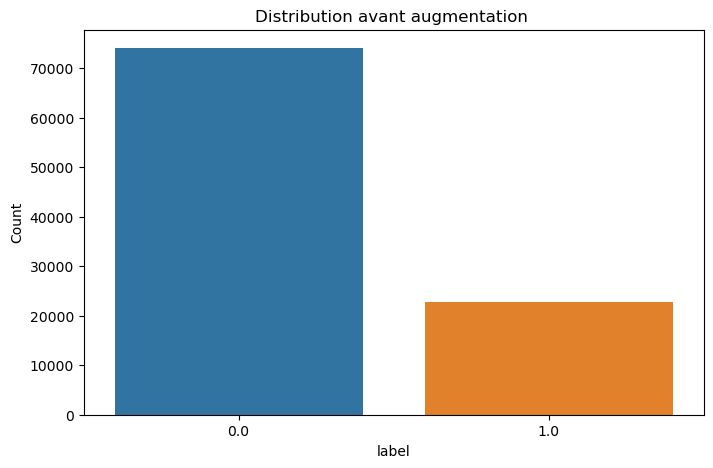

In [96]:
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train)

plt.xlabel('label')
plt.ylabel('Count')
plt.title('Distribution avant augmentation ')

plt.show()

Dans le train il y a beaucoup d'url légitimes et peu d'url de phishing

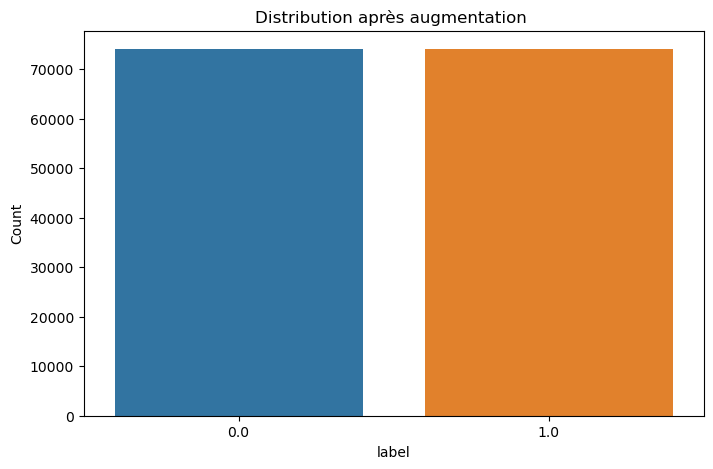

In [97]:
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train_smote)

plt.xlabel('label')
plt.ylabel('Count')
plt.title('Distribution après augmentation ')

plt.show()

Nous avons maintenant un jeu de données équilibrée

Accuracy: 0.9677659310686834
Confusion Matrix:
 [[18330   281]
 [  499  5088]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.98     18611
         1.0       0.95      0.91      0.93      5587

    accuracy                           0.97     24198
   macro avg       0.96      0.95      0.95     24198
weighted avg       0.97      0.97      0.97     24198

Execution Time: 8.2171 seconds


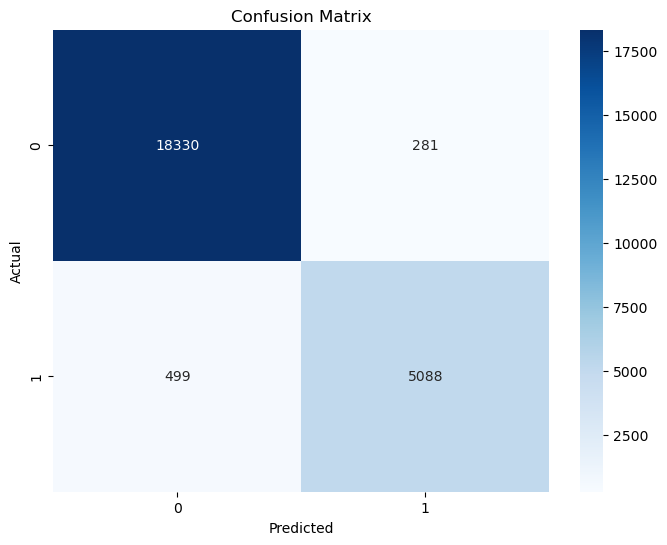

In [23]:
apply_model(X_train_smote, y_train_smote, X_test, y_test, logistic_model)

On remarque que le recall a diminué de **1%** (de **99%** à **98%**) sur les url légitime et a augmenté de `6%` sur les url de phishing (de **85%** à **91%**).

L'augmentation de donnée a donc **amélioré** les performances du modèle.

Dans la suite nous allons tester l'ajout de variable pour améliorer le modèle.

## Regression logistique et Ajout de variables

L'ensemble des variable ajouté est décrit dans le tableau ci-dessous

| variable           | description              |
|--------------------|--------------------------|
| url_length         | longueur de l'url        |
| num_dots           | nombre de sous domaines  |
| num_hyphens        | nombre de trait (-)      |
| num_at             | nombre de @              |
| num_question_marks | nombre de ?              |
| num_equals         | nombre de =              |
| num_underscores    | nombre de _              |
| num_slashes        | nombre de /              |
| num_digits         | nombre de chiffre        |
| has_https          | contient https           |
| has_www            | contient www             |


Toutes ces variables sont issues de l'url

In [24]:
# Fonction pour extraire des caractéristiques
def add_columns(url):
    features = {}
    features['url_length'] = len(url)
    features['num_dots'] = url.count('.')
    features['num_hyphens'] = url.count('-')
    features['num_at'] = url.count('@')
    features['num_question_marks'] = url.count('?')
    features['num_equals'] = url.count('=')
    features['num_underscores'] = url.count('_')
    features['num_slashes'] = url.count('/')
    features['num_digits'] = sum(c.isdigit() for c in url)
    features['has_https'] = 1 if 'https' in url else 0
    features['has_www'] = 1 if 'www' in url else 0
    return features
features_df = df['domain'].apply(lambda url: pd.Series(add_columns(url)))


### Etude de la correlation entre les variables ajoutées

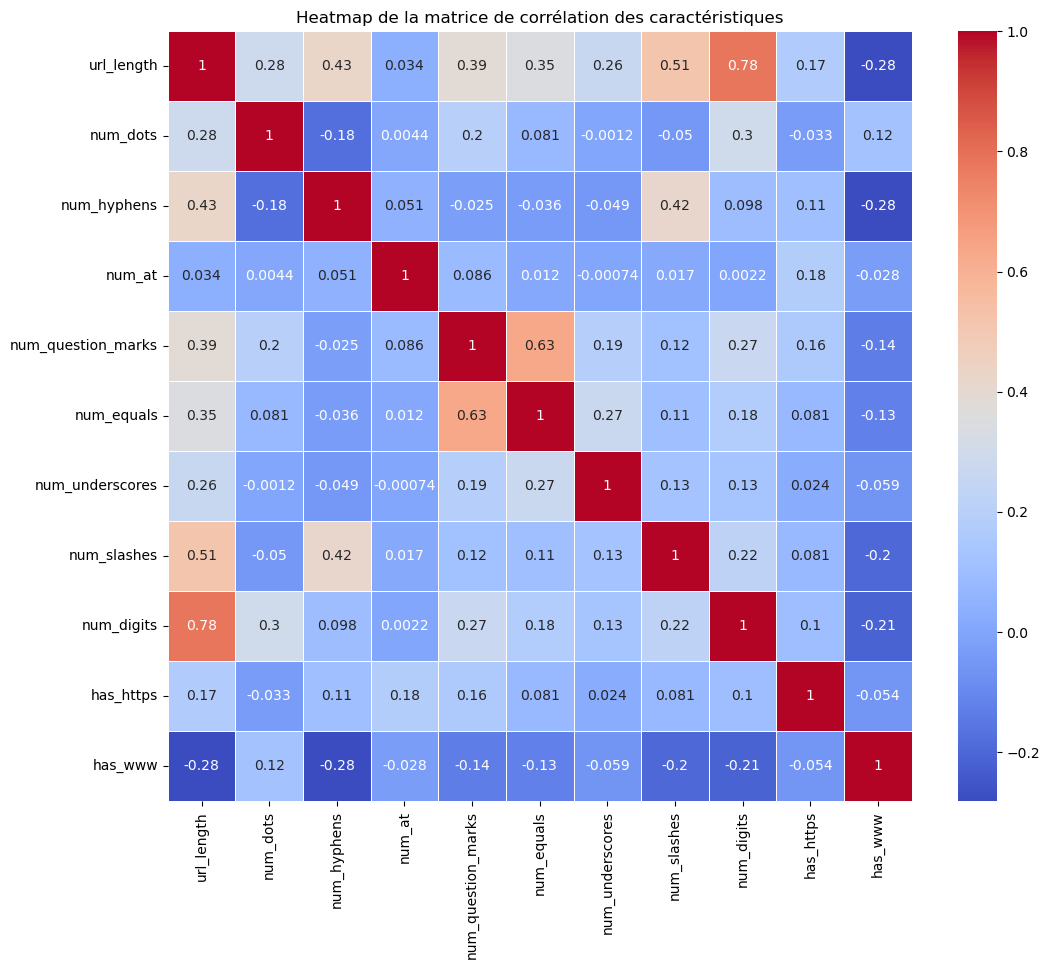

In [25]:

correlation_matrix = features_df.corr()
plt.figure(figsize=(12, 10))

# Dessiner le heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap de la matrice de corrélation des caractéristiques')
plt.show()


Nous allons supprimer les colonnes **url_length** et **num_equals**  qui ont toutes les deux une corrélation supérieur 0.6 avec les colonnes **num_digit** et **num_equals**

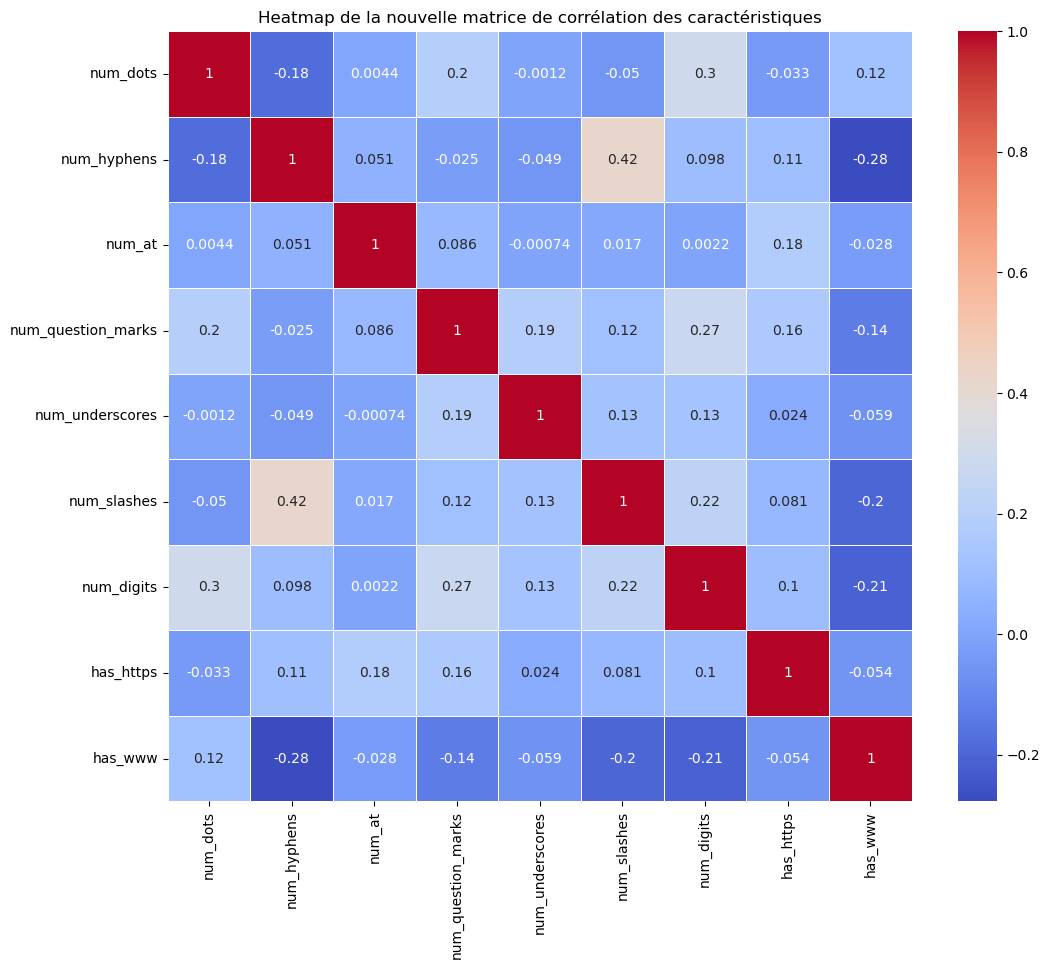

In [26]:
correlation_matrix_new = features_df.drop(columns=['url_length', 'num_equals']).corr()
plt.figure(figsize=(12, 10))

# La HeatMap
sns.heatmap(correlation_matrix_new, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap de la nouvelle matrice de corrélation des caractéristiques')
plt.show()

Nous avons de nouvelles variables dans le dataset sans correlation

In [27]:
# Ajout des nouvelles caractéristiques au dataframe
features_df.drop(columns=['url_length', 'num_equals'], inplace = True)
df = pd.concat([df, features_df], axis=1)

In [40]:
def vectorize_features(data):
    """
    Fonction pour vectoriser les caractéristiques extraites à partir des URLs.

    Paramètres :
    - data : DataFrame contenant les données à vectoriser.

    Retourne :
    - X_tfidf : Matrice TF-IDF des caractéristiques vectorisées.
    """
    # Ajout de nouvelles caractéristiques extraites
    data['url_segments'] = data['domain'].apply(lambda x: x.split('/'))
    data['url_segments_str'] = data['url_segments'].apply(lambda x: ' '.join(x))
    
    # Vectorisation des nouvelles caractéristiques
    vectorizer = TfidfVectorizer(ngram_range=(1, 3))
    X_tfidf = vectorizer.fit_transform(data['url_segments_str'])

    return X_tfidf

import scipy.sparse as sp


# Génération des features supplémentaires
features_df = df['domain'].apply(lambda url: pd.Series({
    'num_dots': url.count('.'),
    'num_hyphens': url.count('-'),
    'num_at': url.count('@'),
    'num_question_marks': url.count('?'),
    'num_underscores': url.count('_'),
    'num_slashes': url.count('/'),
    'num_digits': sum(c.isdigit() for c in url),
    'has_https': 1 if 'https' in url else 0,
    'has_www': 1 if 'www' in url else 0
}))

# Vectorisation des segments d'URL
X_tfidf = vectorize_features(df)
# Conversion des caractéristiques supplémentaires en matrice sparse
X_additional = sp.csr_matrix(features_df.values)
X_combined = sp.hstack([X_tfidf, X_additional])

X_train_c, X_test, y_train_c, y_test = train_test_split(X_combined, df['label'], test_size=0.2, random_state=42)

Accuracy: 0.9609058599884288
Confusion Matrix:
 [[18420   191]
 [  755  4832]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     18611
         1.0       0.96      0.86      0.91      5587

    accuracy                           0.96     24198
   macro avg       0.96      0.93      0.94     24198
weighted avg       0.96      0.96      0.96     24198

Execution Time: 176.4875 seconds


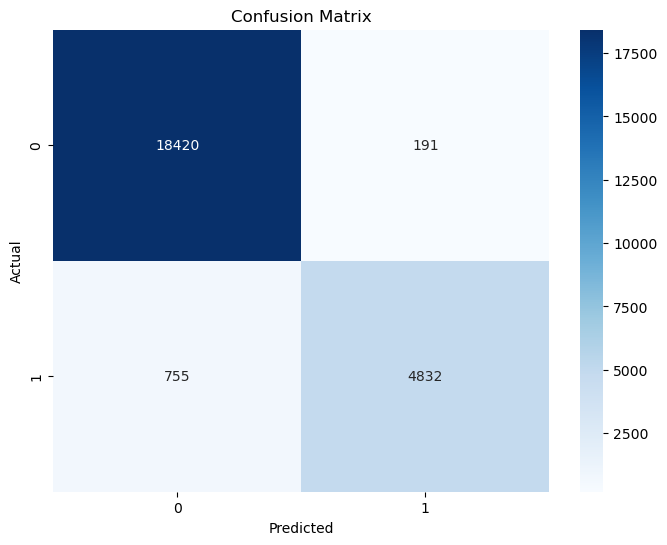

In [41]:
apply_model(X_train_c, y_train_c, X_test, y_test, logistic_model)


L'ajout de variable permet d'augmenter la précision du modèle (recall) a détecter les urls de phisihing de **1%** sur la regression logistique simple.

Que se passerait-il si l'on combinait l'ajout de variable et l'augmentation de données ?

### Regression logistique  : Augmentation de données et Ajout de variables

In [29]:
smote = SMOTE(random_state=42)
X_train_smote_c, y_train_smote_c = smote.fit_resample(X_train_c, y_train_c)

Accuracy: 0.9656169931399289
Confusion Matrix:
 [[18119   492]
 [  340  5247]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.97      0.98     18611
         1.0       0.91      0.94      0.93      5587

    accuracy                           0.97     24198
   macro avg       0.95      0.96      0.95     24198
weighted avg       0.97      0.97      0.97     24198

Execution Time: 217.2261 seconds


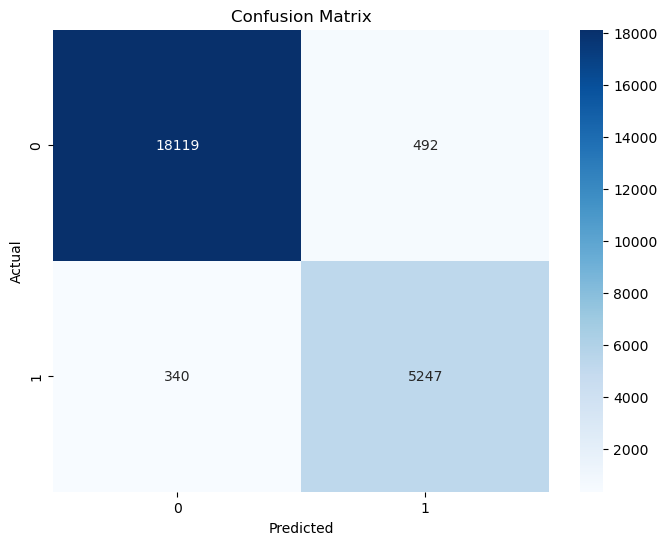

In [30]:
apply_model(X_train_smote_c, y_train_smote_c, X_test, y_test, logistic_model)


L'ajout de variables sur les données augmentées permet d'augmenter de **3%** les capacités du modèle à détecter  les urls de phishing (recall).

La regression logistique est un algorithme linéaire, nous allons donc tester d'autres algorithmes qui sont mieux adaptés pour gérer la non linéarité des données.

# Modele lightGBM

Dans l'état de l'art **SK Hasane Ahammad et al.** ont utilisé plusieurs modèles dans la détection de phisihing des url avec de l'IA et où `lightGBM` avait les meilleurs performances.
[cliquez ici](https://www.researchgate.net/publication/365790574_Phishing_URL_detection_using_machine_learning_methods)

Nous reprenons le meme processus fait avec la regression logistique mais cette fois-ci avec lightGBM.

### LightGBM Simple

[LightGBM] [Info] Number of positive: 22723, number of negative: 74069
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.435290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 302555
[LightGBM] [Info] Number of data points in the train set: 96792, number of used features: 10853
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.234761 -> initscore=-1.181619
[LightGBM] [Info] Start training from score -1.181619
Accuracy: 0.9244565666584015
Confusion Matrix:
 [[18417   194]
 [ 1634  3953]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.99      0.95     18611
         1.0       0.95      0.71      0.81      5587

    accuracy                           0.92     24198
   macro avg       0.94      0.85      0.88     24198
weighted avg       0.93      0.92      0.92     24198

Execution Time: 13.2557 seconds


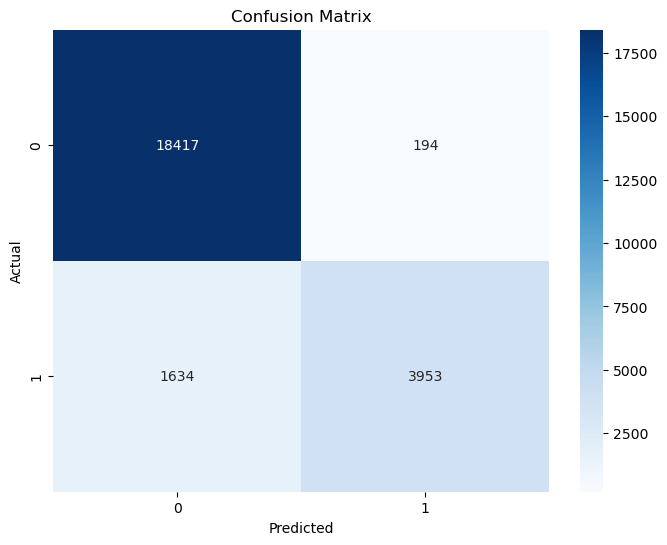

In [38]:
import lightgbm as lgb

lgbm_model = lgb.LGBMClassifier(random_state=42)
apply_model(X_train, y_train, X_test, y_test, lgbm_model)

contrairement à la regression logistique lightGBM détecte moins les urls de phishing. En effet, nous avons **85%** contre **71%** [voir ici](création-dun-modéle-simple--regression-logistique)

## LightGBM et Augmentation de données

[LightGBM] [Info] Number of positive: 22723, number of negative: 74069
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.900450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 302957
[LightGBM] [Info] Number of data points in the train set: 96792, number of used features: 10862
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.234761 -> initscore=-1.181619
[LightGBM] [Info] Start training from score -1.181619
Accuracy: 0.9755351681957186
Confusion Matrix:
 [[18313   298]
 [  294  5293]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     18611
         1.0       0.95      0.95      0.95      5587

    accuracy                           0.98     24198
   macro avg       0.97      0.97      0.97     24198
weighted avg       0.98      0.98      0.98     24198

Execution Time: 16.3893 seconds


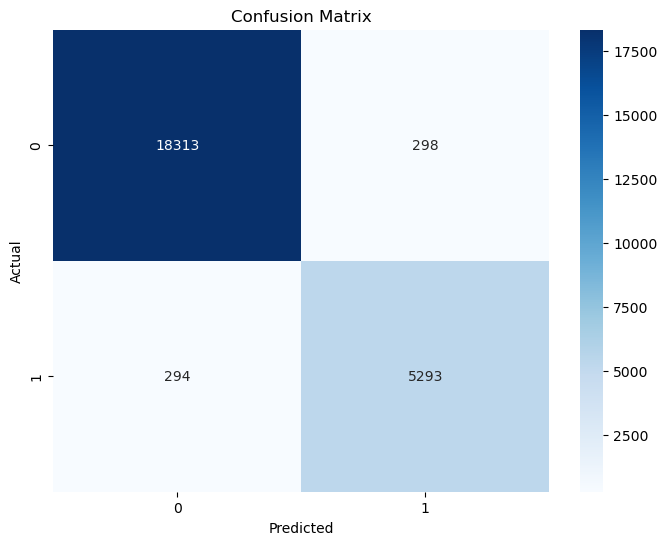

In [42]:
apply_model(X_train_c, y_train_c, X_test, y_test, lgbm_model)


D'après les resultats ci-dessus, on constate que lightGBM est plus efficace avec les données augmenté par rapport la regression logistique avec les données augmentées.

On peut ainsi dire que lightGBM est performant lorsque les données sont équilibrées.

### LighGBM : Augmentation de données et Ajout de variables

[LightGBM] [Info] Number of positive: 74069, number of negative: 74069
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 5.143967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 550983
[LightGBM] [Info] Number of data points in the train set: 148138, number of used features: 20691
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.9730969501611704
Confusion Matrix:
 [[18135   476]
 [  175  5412]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     18611
         1.0       0.92      0.97      0.94      5587

    accuracy                           0.97     24198
   macro avg       0.95      0.97      0.96     24198
weighted avg       0.97      0.97      0.97     24198

Execution Time: 33.8372 seconds


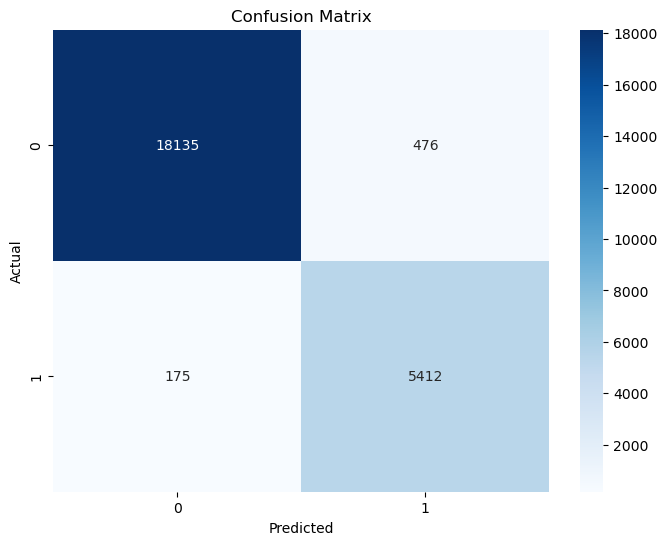

In [43]:
apply_model(X_train_smote_c, y_train_smote_c, X_test, y_test, lgbm_model)


Avec les données augmentées et l'ajout de variables, lightGBM est nettement meilleurs dans la détection des urls de phishing et légitmes.

Pour la suite, nous allons tester **l'augmentation des données et l'ajou**t de variables sur différents modèles de classification

# Autres models 

In [ ]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

## XGBOOST

In [44]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

Accuracy: 0.9687990743036614
Confusion Matrix:
 [[18023   588]
 [  167  5420]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     18611
         1.0       0.90      0.97      0.93      5587

    accuracy                           0.97     24198
   macro avg       0.95      0.97      0.96     24198
weighted avg       0.97      0.97      0.97     24198

Execution Time: 140.6768 seconds


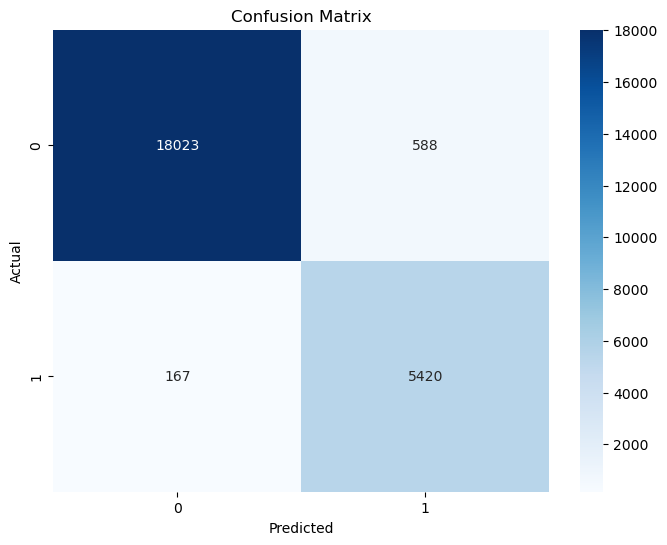

In [45]:
apply_model(X_train_smote_c, y_train_smote_c, X_test, y_test, xgb_model)


## SVC

Accuracy: 0.8385403752376229
Confusion Matrix:
 [[15121  3490]
 [  417  5170]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.81      0.89     18611
         1.0       0.60      0.93      0.73      5587

    accuracy                           0.84     24198
   macro avg       0.79      0.87      0.81     24198
weighted avg       0.89      0.84      0.85     24198

Execution Time: 3353.8477 seconds


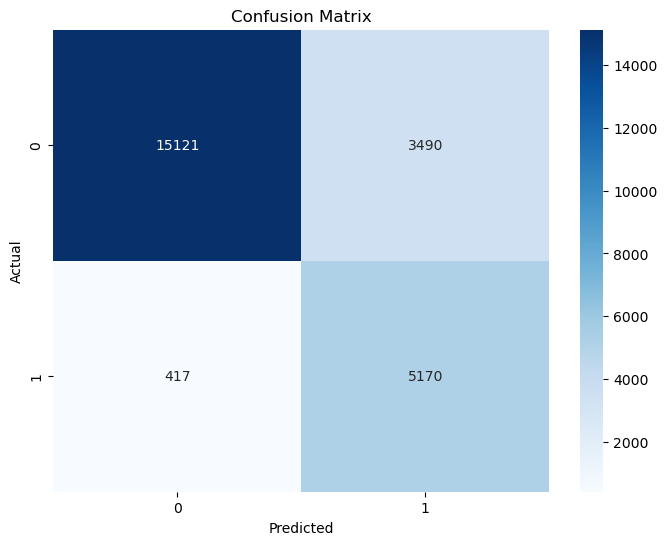

In [47]:
svm_model = SVC()
apply_model(X_train_smote_c, y_train_smote_c, X_test, y_test, svm_model)


## Decision Tree

Accuracy: 0.9730556244317712
Confusion Matrix:
 [[18272   339]
 [  313  5274]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     18611
         1.0       0.94      0.94      0.94      5587

    accuracy                           0.97     24198
   macro avg       0.96      0.96      0.96     24198
weighted avg       0.97      0.97      0.97     24198

Execution Time: 230.1074 seconds


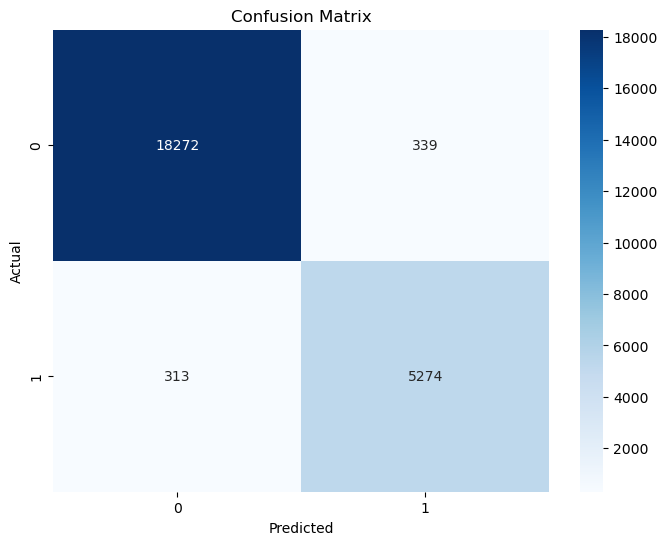

In [48]:
decision_tree_model = DecisionTreeClassifier()
apply_model(X_train_smote_c, y_train_smote_c, X_test, y_test, decision_tree_model)


## KNN

Accuracy: 0.8356475741796843
Confusion Matrix:
 [[14766  3845]
 [  132  5455]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.79      0.88     18611
         1.0       0.59      0.98      0.73      5587

    accuracy                           0.84     24198
   macro avg       0.79      0.88      0.81     24198
weighted avg       0.90      0.84      0.85     24198

Execution Time: 695.7374 seconds


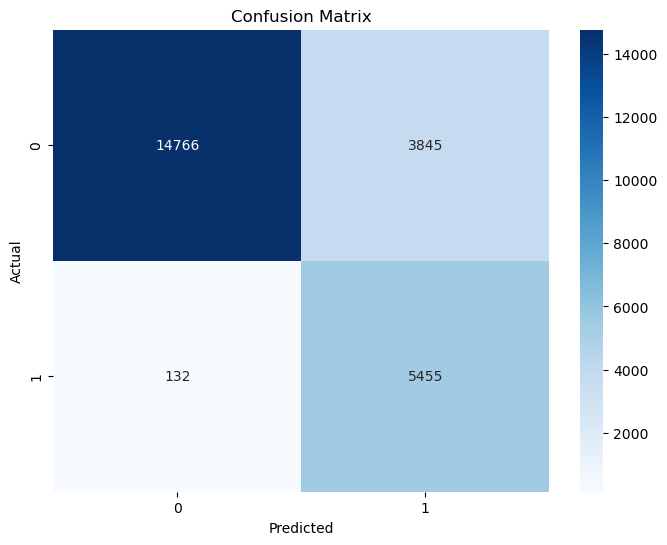

In [49]:
knn_model = KNeighborsClassifier()
apply_model(X_train_smote_c, y_train_smote_c, X_test, y_test, knn_model)


## Random Forest

Accuracy: 0.9846268286635259
Confusion Matrix:
 [[18418   193]
 [  179  5408]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     18611
         1.0       0.97      0.97      0.97      5587

    accuracy                           0.98     24198
   macro avg       0.98      0.98      0.98     24198
weighted avg       0.98      0.98      0.98     24198

Execution Time: 4897.9645 seconds


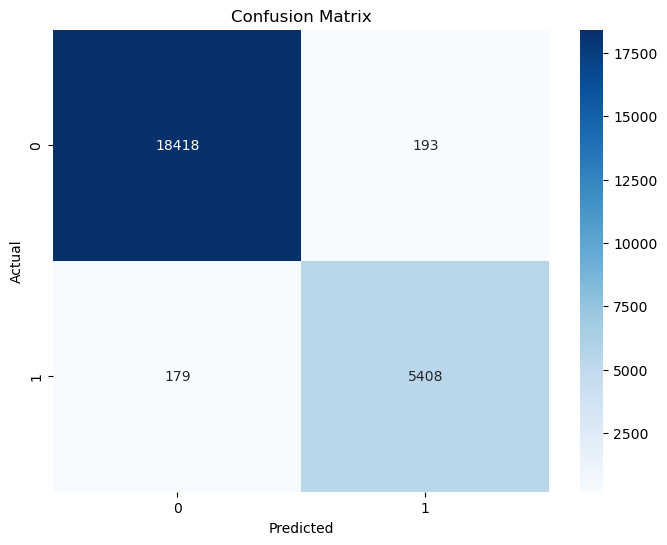

In [50]:

random_forest_model = RandomForestClassifier()
apply_model(X_train_smote_c, y_train_smote_c, X_test, y_test, random_forest_model)


## Gradient Boosting

Accuracy: 0.9277212992809323
Confusion Matrix:
 [[17009  1602]
 [  147  5440]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.91      0.95     18611
         1.0       0.77      0.97      0.86      5587

    accuracy                           0.93     24198
   macro avg       0.88      0.94      0.91     24198
weighted avg       0.94      0.93      0.93     24198

Execution Time: 11112.9818 seconds


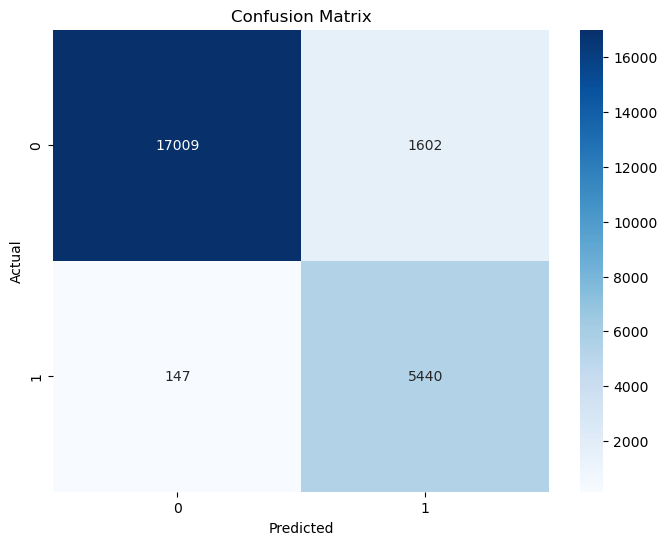

In [51]:
gradient_boosting_model = GradientBoostingClassifier()
apply_model(X_train_smote_c, y_train_smote_c, X_test, y_test, gradient_boosting_model)


#### Resultats des modèles sur les données augmentées et ajout de varaible

| Modèles             | recall sur 0(%) | recall sur 1 (%) |
|---------------------|-----------------|------------------|
| Logistic regression | 97              | 94               |
| lightGBM            | 97              | 97               |
| XGBoost             | 97              | 97               |
| SVM                 | 81              | 93               |
| Decision Tree       | 98              | 94               |
| KNN                 | 79              | 98               |
| `Random Forest`     | `99`            | `97`             |
| Gradient Boosting   | 91              | 97               |

Random forest est le modèle qui a les meilleurs performances ensuite vient lightGBM et XGBoost

## Model de stacking

Nous allons construire un modèle de stacking avec les meilleurs modèles mais dans un 1er temps sans random forest et ennsuite un autre stacking incluant random forest.

Ce 1er stacking est pour vérifier si **l'ensemble learning** améliore les prédictions dans la classification des urls.

NB: Nous n'utilisons pas **Decison tree** dans la suite car sa version améliorée qui est random forest a des meilleurs resultats

[LightGBM] [Info] Number of positive: 74069, number of negative: 74069
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.470059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 550983
[LightGBM] [Info] Number of data points in the train set: 148138, number of used features: 20691
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 59255, number of negative: 59255
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 4.078601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 456391
[LightGBM] [Info] Number of data points in the train set: 118510, number of used features: 17360
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 59255, number of negative: 59255
[LightGBM] [Info] Auto-choosing col-wis

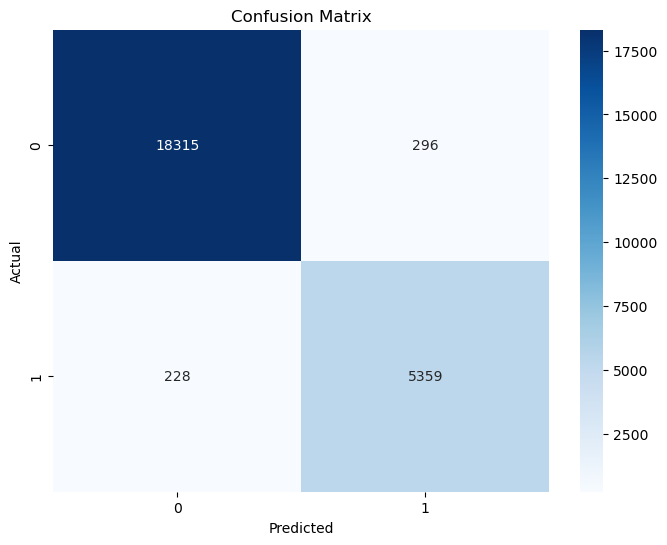

In [54]:

from sklearn.ensemble import StackingClassifier, RandomForestClassifier

# liste des modèles de base pour le stacking
estimators = [
    ('lightgbm', lgbm_model),
    ('xgboost', xgb_model),
    ('logistic_regression', logistic_model)
]

# Instance du modèle de stacking
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
)

apply_model(X_train_smote_c, y_train_smote_c, X_test, y_test, stacking_model)


Le stacking dans ce contexte ne fait pas mieux que le random forest 

## Stacking avec random forest 

[LightGBM] [Info] Number of positive: 74069, number of negative: 74069
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 10.874226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 550983
[LightGBM] [Info] Number of data points in the train set: 148138, number of used features: 20691
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 59255, number of negative: 59255
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.863067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 456391
[LightGBM] [Info] Number of data points in the train set: 118510, number of used features: 17360
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 59255, 

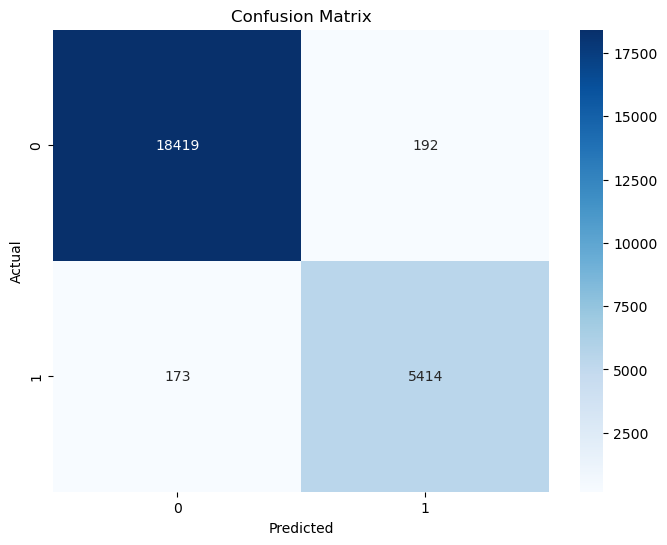

In [55]:

from sklearn.ensemble import StackingClassifier, RandomForestClassifier

# liste des modèles de base pour le stacking
estimators = [
    ('lightgbm', lgbm_model),
    ('random_forest', random_forest_model),
    ('xgboost', xgb_model),
    ('logistic_regression', logistic_model)
]

# Instance du modèle de stacking
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
)

apply_model(X_train_smote_c, y_train_smote_c, X_test, y_test, stacking_model)


Le stacking dans ce contexte a les memes resultats que le random forest. 

Ainsi, il est préférable du d'utiliser le random forest et non le stacking qui est un modèle plus complexe.

**Random forest est donc le modèle que nous utiliserons dans la classification des urls de phisihing et légitime.**

## Sauvegarde des modèles

In [62]:
import os
import joblib
os.makedirs('models', exist_ok=True)

def save_model(model, model_name):
    model_path = os.path.join('models', model_name + ".pkl")
    joblib.dump(model, model_path)
    print(f"Model saved to {model_path}")

In [63]:
save_model(xgb_model, "xgb_model")
save_model(lgbm_model, "lgbm_model")
save_model(svm_model, "svm_model")
save_model(decision_tree_model, "decision_tree_model")

Model saved to models\xgb_model.pkl
Model saved to models\lgbm_model.pkl
Model saved to models\svm_model.pkl
Model saved to models\decision_tree_model.pkl


# Importance des variables

impo  9
<class 'numpy.ndarray'>
[8 5 6 1 0 4 3 7 2] <class 'numpy.ndarray'>
[0.0452343  0.02489978 0.01442499 0.01359137 0.01180952 0.00191644
 0.00155139 0.00100188 0.00010628] <class 'numpy.ndarray'>
['has_www' 'num_slashes' 'num_digits' 'num_hyphens' 'num_dots'
 'num_underscores' 'num_question_marks' 'has_https' 'num_at'] <class 'pandas.core.indexes.base.Index'>


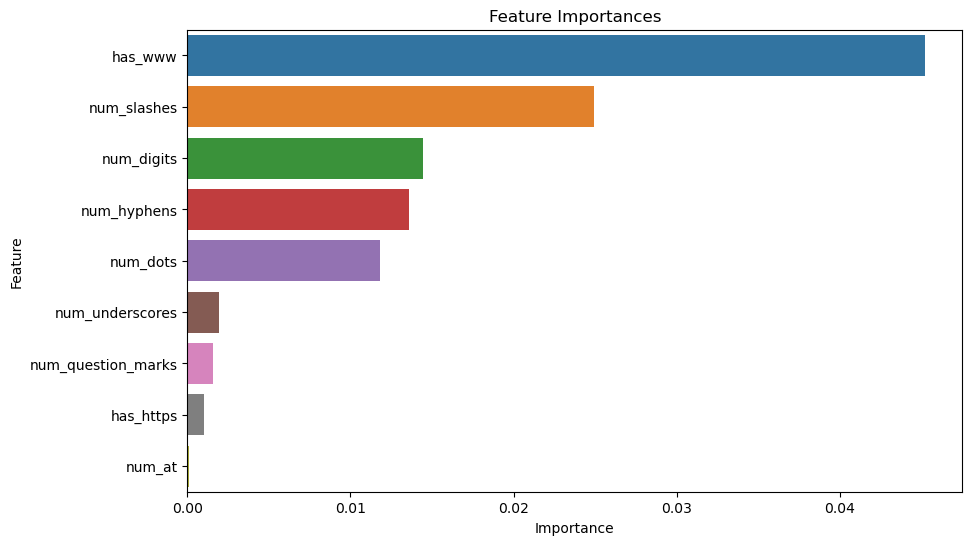

In [79]:
import numpy as np
feature_names = features_df.columns

importances = random_forest_model.feature_importances_[-9:]
print("impo ",len(importances))
print(type(importances))
# Create a bar plot for feature importances
def plot_feature_importances(importances, feature_names):
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10, 6))
    print(indices, type(indices))
    print(importances[indices], type(importances))
    print(np.array(feature_names)[indices], type(feature_names))
    sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
    plt.title('Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# Plot the feature importances
plot_feature_importances(importances, features_df.columns)

La presence de **www** influence beaucoup sur la décision du modèle tandisque le nombre de **@** n'a pas d'influence

# II- Supervision du modèle et gestion de drifting 

### II-1  Stratégie de détection de drift dans les données

- Surveiller la performance du modèle 
- Test de Kolmogorov-Smirnov (KS) : Comparer les distributions des caractéristiques entre les ensembles de données d'entraînement et les nouvelles données
- Entraînement de modèles de détection de drift : Utiliser des modèles pour classifier si les données proviennent de la distribution d'entraînement ou de nouvelles données.
- Réentraînement périodique : Entraîner régulièrement un modèle de surveillance sur les nouvelles données et comparer ses performances avec le modèle actuel.

- Utiliser les bibliothèque Alibi Detect  ou River qui pour détecter le drift de manière continue.

### II-2 Méthode pour incorporer de nouvelles données dans le modèle 

- Avoir un datalake ou datawarehouse centralisé de nouvelles donnée
- recueilli les feeback des utilisateur pour alimenter la base d'entrainement
- Réentraîner le modèle périodiquement avec les  données les plus recentes
- Faire un entrainement complet du modèle avec l'ensemble des données (anciennes et nouvelles)

## II-3 Surveillance du modèle au fil du temps

- Tests A/B : Comparer les performances du modèle actuel avec une version précédente ou un modèle de référence sur des échantillons de données.
- Contrôles manuels : Faire vérifier manuellement un sous-ensemble des prédictions pour s'assurer de leur pertinence.